In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train_ZoGVYWq.csv")
test = pd.read_csv("../data/test_66516Ee.csv")
submission = pd.read_csv("../data/sample_submission_sLex1ul.csv")

# Setup Data

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [4]:
#SETUP DATA
data = pd.concat([train, test], axis=0).reset_index(drop = True)
data["sourcing_channel"] = LabelEncoder().fit_transform(data["sourcing_channel"])
data["residence_area_type"] = LabelEncoder().fit_transform(data["residence_area_type"])

In [5]:
train = data[:train.shape[0]].reset_index(drop =True)
test = data[train.shape[0]:].reset_index(drop =True)

train_id = train[["id"]]
test_id = test[["id"]]
target = train.renewal

train = train.drop(["id","renewal"], axis=1)
test = test.drop(["id","renewal"], axis=1)

# Running  Model

In [6]:
import lightgbm as lgb
def model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train,categorical_feature = ["sourcing_channel","residence_area_type"])
    dval = lgb.Dataset(x_test, label=y_test, categorical_feature = ["sourcing_channel","residence_area_type"])
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 1,
        "metric":"auc",
        "objective": "binary",
        "learning_rate":0.15,
        "num_leaves":5,
        "max_depth":5,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 232323,
        "seed":324343
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))
    
    global meta_train_tid
    meta_train_tid[train_index] = model.predict(x_train, num_iteration=model.best_iteration or 5000)

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [7]:
meta_train = np.zeros(train.shape[0])
meta_train_tid = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=43434)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", roc_auc_score(target, meta_train)

test_id["renewal"] = pd.DataFrame(np.array(meta_test).T).rank(pct = True, axis=0).mean(axis=1)
train_id["renewal"] = meta_train
train_id["renewal_tid"] = meta_train_tid

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.854041	valid_1's auc: 0.840073
[200]	training's auc: 0.863424	valid_1's auc: 0.838934
Early stopping, best iteration is:
[92]	training's auc: 0.853039	valid_1's auc: 0.840531
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.852879	valid_1's auc: 0.84839
[200]	training's auc: 0.86172	valid_1's auc: 0.847147
Early stopping, best iteration is:
[59]	training's auc: 0.846997	valid_1's auc: 0.84869
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.856368	valid_1's auc: 0.828535
[200]	training's auc: 0.865108	valid_1's auc: 0.827206
[300]	training's auc: 0.872658	valid_1's auc: 0.826114
Early stopping, best iteration is:
[104]	training's auc: 0.856664	valid_1's auc: 0.828821
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.853685	valid_1's auc: 0.84043
[200]	training's auc: 0.862989	valid_1's auc

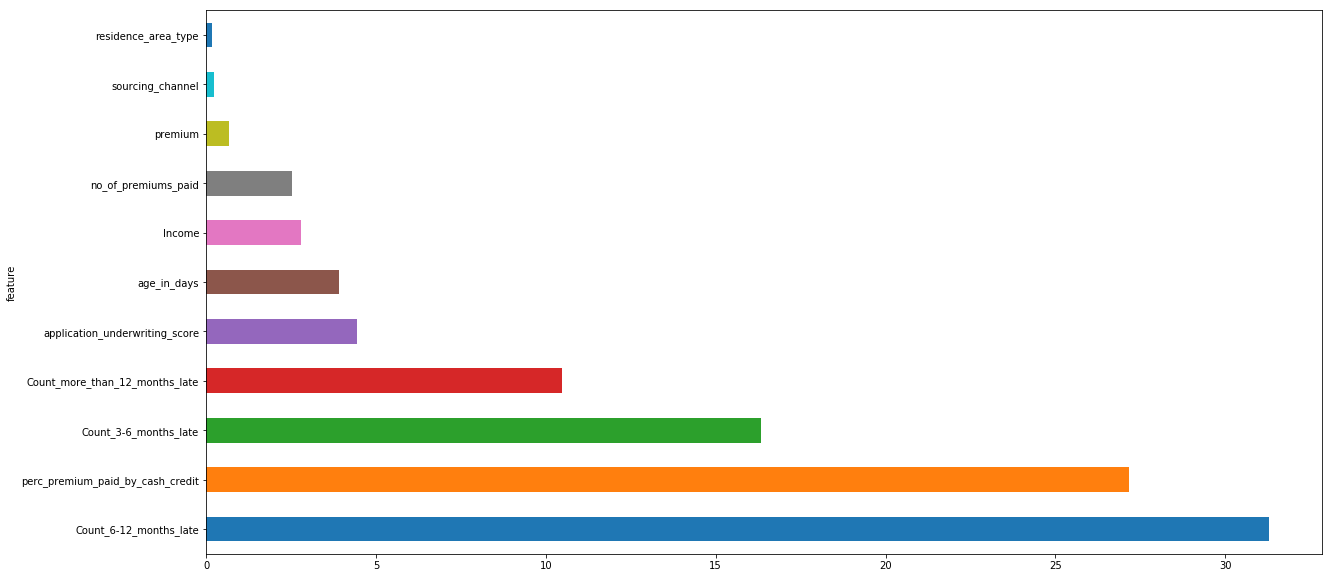

In [8]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


# Working on Incentives

In [9]:
def get_effort(incentive):
    return 10*(1-np.exp(-incentive/400.0))
    
def get_improvement_in_renewal_probability(incentive):
    effort = get_effort(incentive)
    return 20*(1-np.exp(-effort/5.0))

def gradient_improvement_in_renewal_probability(incentive):
    dpde = 4 * np.exp(-get_effort(incentive)/5.0)
    dedi = np.exp(-incentive/400.0)/40.0
    dpdi = dpde * dedi
    return  dpdi
    
def revenue_score(incentive, benchmark, premium):
    cdp = get_improvement_in_renewal_probability(incentive)
    profits = ((benchmark + (cdp*benchmark/100.0)) * premium)-incentive
    return np.sum(profits)

def score_gradient(incentive, benchmark, premium):
    z=  np.exp(-incentive/400.0)-(incentive/400.0)-2
    return ((benchmark * premium * np.exp(z)/400.0)-1)

def second_score_gradient(incentive, benchmark, premium):
    a = np.exp(-incentive/400.0)-(incentive/400.0)
    b = (benchmark* premium* np.exp(a))/400.0
    return (-(b)-(1.0/400.0))/400.0

def learn(benchmark, premium, early_stopping = 5, start_incentive = 1700, min_improvement = 0.005, verbose = True):
    incentive = start_incentive
    best_incentive = start_incentive
    
    score = 0
    best_score = 0
    
    counter = 0
    best_counter = 0
    no_improvement_counter = 0
    
    while True:
        lr = (incentive - 0)
        gradient = score_gradient(incentive, benchmark, premium)
        try:
            incentive += lr*(gradient*0.5 + 0.5*prev_gradient)
        except:
            incentive += lr*gradient
            
        
        score = revenue_score(incentive, benchmark, premium)
        counter +=1
        prev_gradient = gradient

        if (score-best_score> min_improvement):
            best_score = score
            best_incentive = incentive
            best_counter = counter
            
            no_improvement_counter = 0
            if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
        else:
            if (no_improvement_counter > early_stopping):
                if verbose: print "Early Stopping, Best Iteration Round: {}".format(best_counter)
                return best_incentive, best_score
            else:
                no_improvement_counter +=1
                if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
    

In [10]:
def annealing(benchmark, premium, num_annealing = 30):
    results = []
    for incentive in range(0,premium,int(float(premium)/num_annealing)):
        results.append(learn(benchmark, premium, early_stopping = 5, start_incentive = incentive, min_improvement = 0.005, verbose = False))
    return sorted(results, key = lambda x: x[1])[-1][0]    

In [11]:
train_incentives = []

for i, (benchmark, premium) in enumerate(zip(train_id["renewal"], train["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    train_incentives.append(annealing(benchmark, premium))
    
train_incentives = pd.Series(train_incentives)
train_incentives[train_incentives<0] = 0

generated_score = revenue_score(train_incentives, train_id["renewal"], train["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(train_incentives)), train_id["renewal"], train["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Completed 40000 Rows
Completed 50000 Rows
Completed 60000 Rows
Completed 70000 Rows
Score using generated Incentive: 917173212.639
Score using 1650 as Incentive: 834695075.551
Score Improvement: 1.09881229625


In [12]:
test_incentives = []

for i, (benchmark, premium) in enumerate(zip(test_id["renewal"], test["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    test_incentives.append(annealing(benchmark, premium))
    
test_incentives = pd.Series(test_incentives)
test_incentives[test_incentives<0] = 0

generated_score = revenue_score(test_incentives, test_id["renewal"], test["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(test_incentives)), test_id["renewal"], test["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Score using generated Incentive: 215167225.102
Score using 1650 as Incentive: 173378221.443
Score Improvement: 1.24102798674


# Training for Incentives

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 1,
        "metric":"rmse",
        "objective": "regression",
        "learning_rate":0.05,
        "num_leaves":10,
        "max_depth":10,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 32243434,
        "seed":1223244
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [14]:
train["prediction"] = train_id["renewal"]
test["prediction"] = train_id["renewal"]

meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=123432)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_incentives[train_index], train_incentives[test_index]

    model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", mean_squared_error(train_incentives, meta_train)
test_id["incentives"] = np.array(meta_test).T.mean(axis=1)
train_id["incentives"] = meta_train

test_id["incentives"] += test_incentives
test_id["incentives"] /= 2

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 10.8995	valid_1's rmse: 11.3734
[200]	training's rmse: 7.89157	valid_1's rmse: 8.36673
[300]	training's rmse: 7.26733	valid_1's rmse: 7.86274
[400]	training's rmse: 6.90175	valid_1's rmse: 7.66219
[500]	training's rmse: 6.62107	valid_1's rmse: 7.55444
[600]	training's rmse: 6.39462	valid_1's rmse: 7.4519
[700]	training's rmse: 6.20786	valid_1's rmse: 7.41662
[800]	training's rmse: 6.04216	valid_1's rmse: 7.38876
[900]	training's rmse: 5.89703	valid_1's rmse: 7.35913
[1000]	training's rmse: 5.75494	valid_1's rmse: 7.31452
[1100]	training's rmse: 5.63824	valid_1's rmse: 7.27896
[1200]	training's rmse: 5.52566	valid_1's rmse: 7.2696
[1300]	training's rmse: 5.43024	valid_1's rmse: 7.25382
[1400]	training's rmse: 5.33401	valid_1's rmse: 7.24235
[1500]	training's rmse: 5.24272	valid_1's rmse: 7.23664
[1600]	training's rmse: 5.13482	valid_1's rmse: 7.19988
[1700]	training's rmse: 5.05477	valid_1's rmse: 7.17

[3400]	training's rmse: 4.03461	valid_1's rmse: 6.84524
[3500]	training's rmse: 3.98841	valid_1's rmse: 6.84045
[3600]	training's rmse: 3.94833	valid_1's rmse: 6.84335
[3700]	training's rmse: 3.90878	valid_1's rmse: 6.84673
Early stopping, best iteration is:
[3503]	training's rmse: 3.98741	valid_1's rmse: 6.83995
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 10.8801	valid_1's rmse: 10.7876
[200]	training's rmse: 7.90816	valid_1's rmse: 7.93778
[300]	training's rmse: 7.25326	valid_1's rmse: 7.44324
[400]	training's rmse: 6.89553	valid_1's rmse: 7.2724
[500]	training's rmse: 6.61906	valid_1's rmse: 7.20382
[600]	training's rmse: 6.3939	valid_1's rmse: 7.15444
[700]	training's rmse: 6.20056	valid_1's rmse: 7.12149
[800]	training's rmse: 6.06098	valid_1's rmse: 7.13068
Early stopping, best iteration is:
[678]	training's rmse: 6.2404	valid_1's rmse: 7.118
Overall Score: 51.9620015249


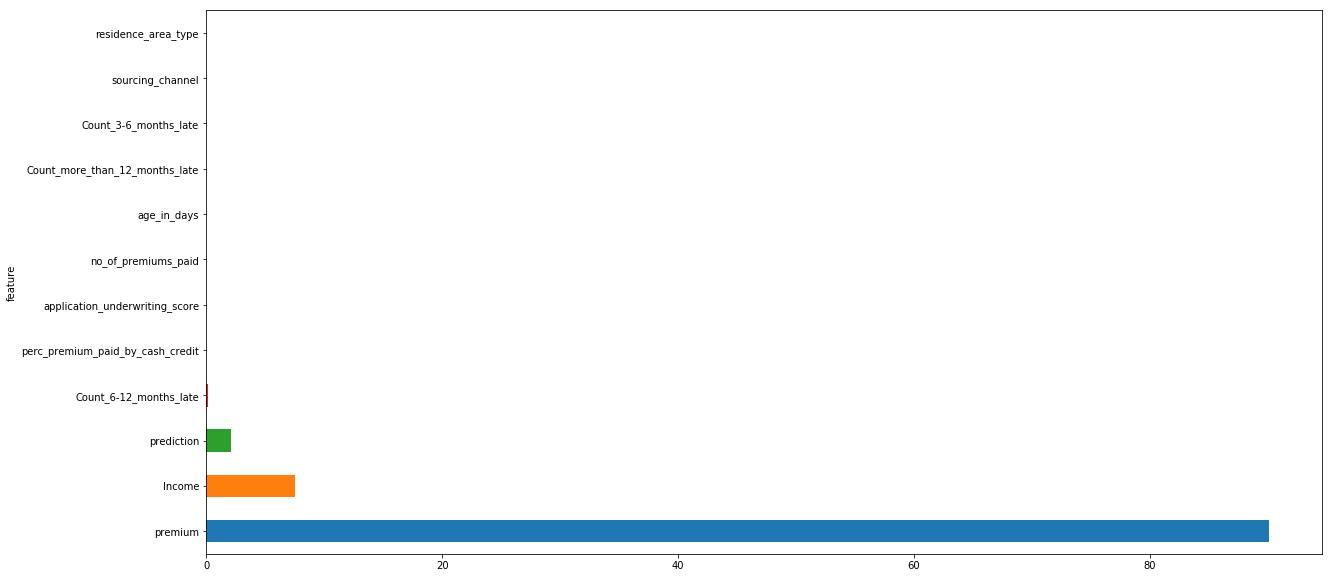

In [15]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


In [16]:
submission = submission[["id"]].merge(test_id[["id","renewal","incentives"]], how = "left", on = "id")
submission = submission[["id", "renewal", "incentives"]]
submission.loc[submission.incentives < 0,"incentives"] = 0
submission.to_csv("csv/eda4.csv", index=False)

In [17]:
submission

id   renewal  incentives
0         649  0.918183  172.530642
1       81136  0.731703  409.237036
2       70762  0.133143  133.123803
3       53935  0.509225  211.645760
4       15476  0.401683  300.946838
5       64797  0.711822  394.398364
6       67412  0.084011   85.019581
7       44241  0.076163   54.840091
8        5069  0.897803  466.674321
9       16615  0.912044  641.257453
10      84281  0.801762  550.955102
11      82623  0.399012   10.127146
12      86475  0.025088  189.114262
13      68263  0.341287   10.733017
14     113135  0.288219    6.205734
15      45532  0.488447  443.784030
16     102161  0.986226  341.564497
17      84789  0.031831  353.083902
18      62398  0.483637  363.849274
19      70148  0.730371   93.579913
20     102487  0.209765  318.947902
21     100513  0.194761  280.382219
22      92702  0.207989  152.188080
23      25051  0.034338  117.657257
24      92920  0.917719  468.716802
25      25520  0.411074  347.765032
26      81869  0.401268  642.147677
27      75402  0.701446  305.339927
28      34053  0.026362   12.093981
29      21191  0.769381  368.851013
...       ...       ...         ...
34194   79950  0.705771  293.817398
34195   30272  0.894472   16.099032
34196   85914  0.994676  482.365358
34197   10922  0.726476  443.203124
34198   93046  0.736851  208.810904
34199   52826  0.333202  423.744767
34200   35994  0.744331  671.516743
34201    1512  0.756326  243.724504
34202   52077  0.447157  233.638007
34203   95749  0.588502  290.881997
34204   49946  0.749433  153.105626
34205   66811  0.665054  351.153739
34206   53438  0.925915   11.626817
34207   24435  0.733777  540.797153
34208   17848  0.512000  368.911464
34209   53626  0.595588  225.678343
34210   87268  0.855251  465.602039
34211   58450  0.577811    8.757185
34212   48188  0.722163  591.990965
34213   44239  0.463680  356.260948
34214   24582  0.272759  216.806245
34215   79939  0.386337  102.153767
34216   63759  0.430721   12.331166
34217   63725  0.039566   87.601930
34218   37116  0.434125  483.248980
34219   81988  0.437278  194.943736
34220   30326  0.593955    1.443187
34221   65749  0.330219   11.495434
34222   65686  0.051432  235.640527
34223   93826  0.400169  123.642758

[34224 rows x 3 columns]